# CPSC 330 Lecture 15

### Lecture plan

- 👋
- **Turn on recording**
- KNN for supervised learning (15 min)
- T/F questions (10 min)
- Intro to NLP (5 min)
- Break (5 min)
- Word counts, TF-IDF (10 min)
- Word embeddings (15 min)
- Useful software package: spaCy (10 min)
- General thoughts on feature engineering (5 min)

## Announcements

- hw6 released, due next Monday at 11:59pm
- Golden Rule violation in Lecture 13 - see https://piazza.com/class/kb2e6nwu3uj23?cid=440
- Midterm grading almost done
- Today's lecture is a bit of a grab bag of topics
  - I am still working on the ideal storyline for Lectures 13-15 (but I know it's out there somehwere!)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scipy.sparse

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from plot_classifier import plot_classifier

In [2]:
plt.rcParams['font.size'] = 16

In [3]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [4]:
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, KeyedVectors, FastText

## KNN for supervised learning (15 min)

#### Classification

- Here is some toy data for binary classification.
- I want to predict the point in grey.

![](img/scatter.png)

- An intuitive way to do this is predict the grey point using the same label as the next "closest" point ($k = 1$)
- We would predict a target of **1 (orange)** in this case

![](img/scatter_k1.png)


- We could also use the 3 closest points ($k = 3$)...
- We would predict a target of **0 (blue)** in this case

![](img/scatter_k3.png)

Going back to the cities dataset:

In [5]:
cities_df = pd.read_csv('data/cities_USA.csv', index_col=0)

In [6]:
cities_df_train, cities_df_test = train_test_split(cities_df)

In [7]:
X_train = cities_df_train.drop(columns=['vote'])
X_test = cities_df_test.drop(columns=['vote'])
y_train = cities_df_train['vote']
y_test = cities_df_test['vote']

In [8]:
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train, y_train);

In [11]:
#??KNeighborsClassifier

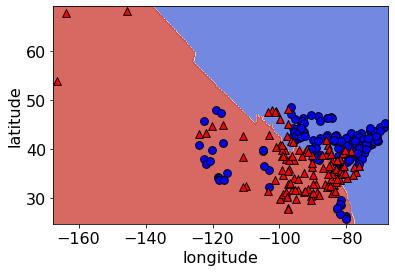

In [9]:
plot_classifier(X_train, y_train, knn, ax=plt.gca(), ticks=True);
plt.ylabel("latitude");
plt.xlabel("longitude");

In [12]:
knn.score(X_train, y_train)

0.74

In [13]:
knn.score(X_test, y_test)

0.69

- $k$ is a hyperparameter
- What happens when we play around with $k$?
  - smaller $k$: lower training error, higher approximation error.

In [14]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train);

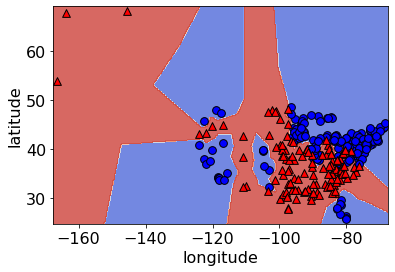

In [15]:
plot_classifier(X_train, y_train, knn, ax=plt.gca(), ticks=True);
plt.ylabel("latitude");
plt.xlabel("longitude");

In [16]:
knn.score(X_train, y_train)

1.0

In [17]:
knn.score(X_test, y_test)

0.96

## Regression

- In KNN regression we take the average of the $k$ nearest neighbours
- Note: regression plots more natural in 1D, classification in 2D, but of course we can do either for any $d$

In [18]:
n = 30 # number of samples
np.random.seed(0) # fix seed for reproducibility
X = np.linspace(-1,1,n)+np.random.randn(n)*0.01
X = X[:, None]
y = np.random.randn(n,1) + X*5

With $k=1$:

In [19]:
knn = KNeighborsRegressor(n_neighbors=1, weights='uniform').fit(X, y)

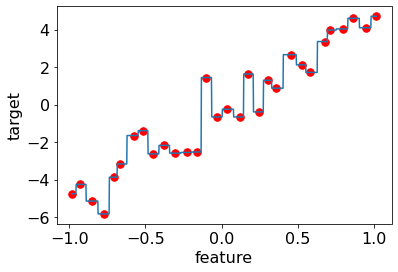

In [20]:
plt.plot(X, y, '.r', markersize=15)
grid = np.linspace(np.min(X), np.max(X), 1000)[:,None]
plt.plot(grid, knn.predict(grid));
plt.xlabel('feature');
plt.ylabel('target');

In [21]:
knn.score(X, y)

1.0

And with $k=10$:

In [22]:
knn = KNeighborsRegressor(n_neighbors=10, weights='uniform').fit(X, y)

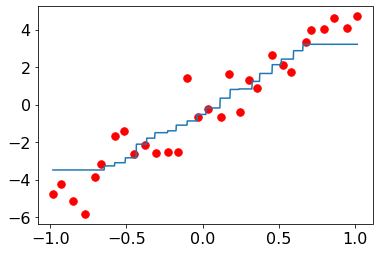

In [23]:
plt.plot(X, y, '.r', markersize=15)
plt.plot(grid, knn.predict(grid));

In [24]:
knn.score(X, y)

0.8671815772959105

In [25]:
knn = KNeighborsRegressor(n_neighbors=10, weights='distance').fit(X, y)

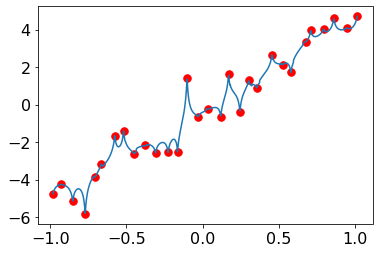

In [26]:
plt.plot(X, y, '.r', markersize=15)
plt.plot(grid, knn.predict(grid));

- So, we have KNN as a new supervised learning technique in our toolbox.
- It can be used for classification or regression (much like the other methods we've seen).
- It works by finding the $k$ closest neighbours to a given "query point".
- This fundamentally relies on a choice of distance.
- sklearn's KNN methods use Euclidean distance by default, but you can set others.

#### Pros/cons of KNN for supervised learning

Pros:

- Easy to understand, interpret.
- Simple hyperparameter controlling the fundamental tradeoff.
- Can learn very complex functions given enough data.

Cons:

- Can be potentially be VERY slow.
- Often not that great test accuracy.

Note: for regular KNN for supervised learning (not with sparse matrices), you should scale your features.

## Neighbours True/False (10 min)

1. Our method from last class would never recommend an item if it had no common reviewers with the query item.
2. If we transposed our item-user matrix into a user-item matrix, we could use all the same methods to find similar users to a query user.
3. KNN classification with $k=1$ is guaranteed to get 100% training accuracy.
4. Unlike linear regression, KNN regression needs to consult the training data when calling `predict`.

## Intro to NLP (5 min)

- Natural Language Processing (NLP) involves extracting information from human language.
- There are many possible NLP tasks for many purposes. Here are just a few examples:
  - translation
  - summarization
  - sentiment analysis
  - relationship extraction
  - question answering / chatbots
- NLP is very difficult! Some examples:

Example: Lexical ambiguity


<img src="img/lexical_ambiguity.png" width="800" height="800">

Example: Part-of-speech ambiguity

<center><img src="img/pos_ambiguity.png" width="800" height="800"></center>

Example: Referential ambiguity


<img src="img/referential_ambiguity.png" width="800" height="800">

- In short, you could do an entire course (or an [entire degree](https://masterdatascience.ubc.ca/programs/computational-linguistics)!) on NLP.
- In this class we'll focus on **turning text into numeric features**.
- We'll use the [IMDB movie review dataset](https://www.kaggle.com/utathya/imdb-review-dataset) from Kaggle, also used in Lecture 4.

In [27]:
imdb_df = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))].drop(columns=['file', 'type'])
df_train, df_test = train_test_split(imdb_df, random_state=123)
df_train.head()

,review,label
6105,This movie was a dismal attempt at recreating ...,neg
9940,"These days, Ridley Scott is one of the top dir...",neg
45421,on the contrary to the person listed above me ...,pos
42236,This is one of those movies that you wish you ...,pos
15382,It's hard for me to explain this show to my gr...,pos


In [29]:
df_train.iloc[1]["review"]

"These days, Ridley Scott is one of the top directors and producers and can command huge sums to helm movies--especially since he has films like ALIEN, GLADIATOR and BLADE RUNNER to his credit. So from this partial list of his credits, it's obvious he's an amazing talent. However, if you watch this very early effort that he made while in film school, you'd probably have a hard time telling that he was destined for greatness. That's because although it has some nice camera-work and style, the film is hopelessly dull and uninvolving. However, considering that it wasn't meant for general release and it was only a training ground, then I am disposed to looking at it charitably--hence the score of 4.<br /><br />By the way, this film is part of the CINEMA 16: European Shorts DVD. On this DVD are 16 shorts. Most aren't great, though because it contains THE MAN WITHOUT A HEAD, COPY SHOP, RABBIT and WASP, it's an amazing DVD for lovers of short films and well worth buying."

### Text data

- How do we feed it into ML algorithms?
- How do we represent the meaning of text?

## Word counts and TF-IDF (10 min)

We've seen `CountVectorizer`:

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
countvec = CountVectorizer()

In [32]:
countvec.fit(df_train["review"]);

In [33]:
X_train_counts = countvec.transform(df_train["review"])

Let's look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

(Note: `??` or shift-tab in Jupyter)

In [ ]:
??CountVectorizer.fit

In [34]:
X_train_counts[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

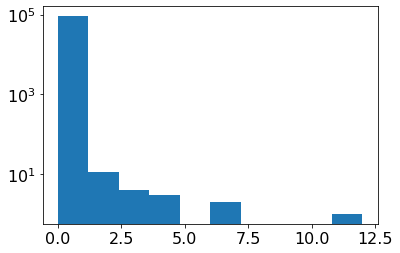

In [35]:
plt.hist(X_train_counts[0].toarray().flatten(), log=True);

- In a few minutes we'll talk about many of these hyperparameters.
- The ones that most simply control the number of features are `max_features`, `min_df`, and `max_df`.

In [36]:
X_train_counts.shape

(37500, 91308)

In [37]:
CountVectorizer(min_df=5).fit_transform(df_train["review"]).shape

(37500, 32743)

In [38]:
CountVectorizer(min_df=5, max_df=100).fit_transform(df_train["review"]).shape

(37500, 27650)

In [39]:
CountVectorizer(min_df=5, max_df=100, max_features=1000).fit_transform(df_train["review"]).shape

(37500, 1000)

In [40]:
CountVectorizer(vocabulary=["good", "bad", "silly", "horrible"]).fit_transform(df_train["review"]).shape

(37500, 4)

## Break (5 min)

REMINDER TO RESUME RECORDING

- `stop_words` removes common words like "the", "and" etc.
- `ngram_range` allows you to consider pairs of words (2), etc.

In [47]:
vec = CountVectorizer(ngram_range=(1,2), min_df=5, max_df=100, 
                      max_features=1000, stop_words="english")
X = vec.fit_transform(df_train["review"])

In [48]:
pd.DataFrame(data=X.toarray(), columns=vec.get_feature_names())

,1933,1939,1940s,1945,1955,1969,1973,1976,1978,1982,...,working class,wrenching,wretched,wright,wwe,www,yard,yawn,yep,youngest
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
#vec.get_feature_names()

#### Term Frequency - Inverse Document Frequency (TF-IDF)

- Intuition: normalize word count by the frequency of the word in the entire dataset.
- If "earthshattering" appears 10 times, that is more meaningful than if "movie" appears 10 times.

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

The shape is the same as what we get from `CountVectorizer`, but the counts are normalized - we won't go into the details.

In [52]:
X_train_tfidf = TfidfVectorizer(max_features=1000).fit_transform(df_train["review"])
X_train_tfidf.shape

(37500, 1000)

In [ ]:
plt.hist(X_train_tfidf[0].toarray().flatten(), log=True);

Let's look at a very simple case:

In [53]:
corpus = [
            "This is the first document, the FIRST",
            "This is the second document",
            "This is the third document",
            "This is the fourth document"
         ]

In [54]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
header = vectorizer.get_feature_names()
labels = ['D1', 'D2', 'D3', 'D4']
df = pd.DataFrame(X.toarray(), columns = header, index = labels)  
df

,document,first,fourth,is,second,the,third,this
D1,1,2,0,1,0,2,0,1
D2,1,0,0,1,1,1,0,1
D3,1,0,0,1,0,1,1,1
D4,1,0,1,1,0,1,0,1


In [55]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
header = vectorizer.get_feature_names()
labels = ['D1', 'D2', 'D3', 'D4']
df = pd.DataFrame(X.toarray(), columns = header, index = labels)  
df

,document,first,fourth,is,second,the,third,this
D1,0.214725,0.822953,0.000000,0.214725,0.000000,0.429451,0.000000,0.214725
D2,0.361028,0.000000,0.000000,0.361028,0.691835,0.361028,0.000000,0.361028
D3,0.361028,0.000000,0.000000,0.361028,0.000000,0.361028,0.691835,0.361028
D4,0.361028,0.000000,0.691835,0.361028,0.000000,0.361028,0.000000,0.361028


Note: there is also [`TfidfTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) which takes the word counts from `CountVectorizer` and transforms them. The output should be the same as if you used `TfidfVectorizer`.

## Word embeddings (15 min)

- Word embeddings: "embed" a word in a vector space.
- You have a bunch of feature columns, each word has a representation.

#### Vector space model

- Model the meaning of a word by placing it into a vector space.  
- Distances among words in the vector space indicate the relationship between them. 

<img src="img/t-SNE_word_embeddings.png" width="700" height="700">

(Attribution: Jurafsky and Martin 3rd edition)

## Embeddings

- This is actually exactly what we did in Lecture 13 with the images.
- We took a pre-trained network, and used it as a transformer that turns images into vectors. 
- We will be doing something similar today.
- But those were trained on a _supervised learning_ task: given an image, predict its class.
- How do we do the same for language?

#### Distributional hypothesis

<blockquote> 
    <p>You shall know a word by the company it keeps.</p>
    <footer>Firth, 1957</footer>        
</blockquote>

<blockquote> 
If A and B have almost identical environments we say that they are synonyms.
<footer>Harris, 1954</footer>    
</blockquote>    

Example: 

- Her **child** loves to play in the playground. 
- Her **kid** loves to play in the playground. 



#### Co-occurrence matrices
- A way to represent vectors into a vector space

#### Term-document matrix

- This like the transpose of `CountVectorizer`.
- Each cell is a count of words in the document in that column. 
- You can describe a document in terms of the frequencies of different words in it. 
- You can describe a word in terms of its frequency in different documents. 

In [56]:
corpus = ['information big data',
        'walnut sugar',
        'apricot big',
        'information data',
        'big data information']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
header = vectorizer.get_feature_names()
labels = ['D1', 'D2', 'D3', 'D4', 'D5']
df = pd.DataFrame(X.toarray(), columns = header, index = labels)  
df.transpose()

,D1,D2,D3,D4,D5
apricot,0,0,1,0,0
big,1,0,1,0,1
data,1,0,0,1,1
information,1,0,0,1,1
sugar,0,1,0,0,0
walnut,0,1,0,0,0


- Note the similarity to the item-user matrix from last class!!


### Term-term matrix

- The idea is to go through a corpus of text, keeping a count of all of the words that appear in its context within a window.

In [57]:
corpus = ['information big data',
        'walnut sugar',
        'apricot big',
        'information data',
        'big data information']

You can ignore the code in the next cell:

In [58]:
vec = CountVectorizer(ngram_range=(1,1)) 
X = vec.fit_transform(corpus)
X_ww = X.T@X
X_ww.setdiag(0) 
header = vec.get_feature_names()
ind_col = header
df = pd.DataFrame(X_ww.toarray(), columns = header, index = ind_col)  
df

,apricot,big,data,information,sugar,walnut
apricot,0,1,0,0,0,0
big,1,0,2,2,0,0
data,0,2,0,3,0,0
information,0,2,3,0,0,0
sugar,0,0,0,0,0,1
walnut,0,0,0,0,1,0


In [ ]:
df_subset = df[['big','data']]
df_subset.iloc[2:]

#### Sparse vs. dense word vectors

- Term-term and term-document matrices are sparse. 
- OK because there are efficient ways to deal with sparse matrices.


#### Alternative 
- Learn short (~100 to 1000 dimensions) and dense vectors. 
- These short dense representations of words are referred to as **word embeddings**.
- Short vectors may be easier to train with ML models (less weights to train).
- They may generalize better.

### How can we get dense vectors?
 
- Count-based methods
    - Singular Value Decomposition (SVD) - beyond the scope of the course
- Prediction-based methods
    - [Word2Vec](https://github.com/tmikolov/word2vec)
    - [fastText](https://fasttext.cc/)
    - [GloVe](https://nlp.stanford.edu/projects/glove/)

### Word2Vec

<img src="img/word2vec.png" width="700" height="700">


#### Success of Word2Vec

- Able to capture complex relationships between words.
- Example: What is the word that is similar to **WOMAN** in the same sense as **KING** is similar to **MAN**?
- Perform a simple algebraic operations with the vector representation of words.
    $\vec{X} = \vec{\text{KING}} − \vec{\text{MAN}} + \vec{\text{WOMAN}}$
- Search in the vector space for the word closest to $\vec{X}$ measured by cosine distance.

<img src="img/word_analogies1.png" width="500" height="500">

(Credit: Mikolov et al. 2013)    


#### Pre-trained embeddings

- These embeddings come from training complicated ML models on big data sets.
- However, we can skip this step and use **pre-trained** embeddings.
- Just like in the computer vision lecture, someone already did `fit` for us and published the results, we can download and just use `transform`.

A number of pre-trained word embeddings are available. Some popular ones are:  

- [word2vec](https://code.google.com/archive/p/word2vec/)
    * trained on several corpora using the word2vec algorithm 
- [GloVe](https://nlp.stanford.edu/projects/glove/)
    * trained using [the GloVe algorithm](https://nlp.stanford.edu/pubs/glove.pdf) 
    * published by Stanford University 
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 
    * trained using [the fastText algorithm](http://aclweb.org/anthology/Q17-1010)
    * published by Facebook

Load Google's pre-trained Word2Vec model:

- Requires download a 1.5 GB zipped file [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing) (3.6 GB unzipped)
- Feel free to just watch the lecture if you don't want to download this huge file!

In [59]:
model = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

In [63]:
print('Size of vocabulary: ', len(model.vocab))

Size of vocabulary:  3000000


In [60]:
word_pairs = [('pineapple','mango'), ('pineapple','juice'), ('sun','robot')]
for pair in word_pairs: 
    print('The similarity between %s and %s is %0.3f' %(pair[0], pair[1], model.similarity(pair[0], pair[1])))

The similarity between pineapple and mango is 0.668
The similarity between pineapple and juice is 0.418
The similarity between sun and robot is 0.029


### Finding similar words
Given word $w$, search in the vector space for the word closest to $w$:

In [ ]:
# model.most_similar('mango')

In [61]:
model.most_similar('UBC')

[('UVic', 0.7886475324630737),
 ('SFU', 0.7588527798652649),
 ('Simon_Fraser', 0.7356574535369873),
 ('UFV', 0.6880435943603516),
 ('VIU', 0.6778583526611328),
 ('Kwantlen', 0.677142858505249),
 ('UBCO', 0.6734487414360046),
 ('UPEI', 0.6731126308441162),
 ('UBC_Okanagan', 0.6709134578704834),
 ('Lakehead_University', 0.6622507572174072)]

In [62]:
model.most_similar('information')

[('info', 0.7363681793212891),
 ('infomation', 0.6800296306610107),
 ('infor_mation', 0.6733849048614502),
 ('informaiton', 0.6639008522033691),
 ('informa_tion', 0.660125732421875),
 ('informationon', 0.633933424949646),
 ('informationabout', 0.6320979595184326),
 ('Information', 0.6186580061912537),
 ('informaion', 0.6093292236328125),
 ('details', 0.6063089370727539)]

#### Finding the odd one out

In [64]:
print(model.doesnt_match("sun moon earth UBC mars".split()))

UBC


/opt/miniconda3/envs/cpsc330env/lib/python3.8/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


#### Distance between sentences

Requires `pip install pyemd` (forgot to put this in the course environment)

In [65]:
sentence_obama = 'Obama speaks to the media in Illinois'.lower().split()
sentence_president = 'The president greets the press in Chicago'.lower().split()
sentence_unrelated = 'Data science is a multidisciplinary blend of data inference, algorithmm development, and technology.'

similarity = model.wmdistance(sentence_obama, sentence_president)
print("Distance between related sentences {:.4f}".format(similarity))

similarity = model.wmdistance(sentence_obama, sentence_unrelated)
print("Distance between unrelated sentences {:.4f}".format(similarity))

Distance between related sentences 2.2813
Distance between unrelated sentences 3.4133


In [66]:
def analogy(word1, word2, word3):
    print('%s : %s :: %s : ?' %(word1, word2, word3))
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=['Analogy word', 'Score'])

In [67]:
analogy('man','king','woman')

man : king :: woman : ?


,Analogy word,Score
0,queen,0.711819
1,monarch,0.618967
2,princess,0.590243
3,crown_prince,0.549946
4,prince,0.537732
5,kings,0.523684
6,Queen_Consort,0.523595
7,queens,0.518113
8,sultan,0.509859
9,monarchy,0.508741


In [68]:
analogy('Montreal', 'Canadiens', 'Vancouver')

Montreal : Canadiens :: Vancouver : ?


,Analogy word,Score
0,Canucks,0.821327
1,Vancouver_Canucks,0.750401
2,Calgary_Flames,0.705470
3,Leafs,0.695783
4,Maple_Leafs,0.691617
5,Thrashers,0.687504
6,Avs,0.681716
7,Sabres,0.665307
8,Blackhawks,0.664625
9,Habs,0.661023


In [69]:
analogy('Microsoft', 'Windows', 'Apple')

Microsoft : Windows :: Apple : ?


,Analogy word,Score
0,Macs,0.673568
1,iMac,0.646340
2,Mac_OS,0.640714
3,iPhone,0.640588
4,iPad,0.633464
5,OS_X,0.632136
6,iBook,0.626197
7,iMacs,0.619245
8,iOS,0.617178
9,Mac_mini,0.611140


In [70]:
analogy('Gauss', 'mathematician', 'Socrates')

Gauss : mathematician :: Socrates : ?


,Analogy word,Score
0,philosopher,0.540793
1,Socrates_Plato,0.478897
2,philosopher_Aristotle,0.467387
3,philosopher_Socrates,0.459890
4,Aristotle,0.455209
5,Philosopher,0.452536
6,logician,0.448070
7,Nobel_laureate_José_Saramago,0.444382
8,poet,0.443180
9,Plato_Socrates,0.441025


#### Implicit biases and stereotypes in word embeddings

- Reflect gender stereotypes present in broader society
- They may also amplify these stereotypes because of their widespread usage 
- See [this paper](http://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf) on debiasing.

In [71]:
analogy('man', 'computer_programmer', 'woman')

man : computer_programmer :: woman : ?


,Analogy word,Score
0,homemaker,0.562712
1,housewife,0.510505
2,graphic_designer,0.505180
3,schoolteacher,0.497949
4,businesswoman,0.493489
5,paralegal,0.492551
6,registered_nurse,0.490797
7,saleswoman,0.488163
8,electrical_engineer,0.479773
9,mechanical_engineer,0.475540


## Useful software package: spaCy (10 min)

In hw6 I have you use `spacy`:

- Very healthy development: https://github.com/explosion/spaCy
- Interactive lessons by Ines Montani: https://course.spacy.io/en/
  -  We're reusing her platform! https://prog-learn.mds.ubc.ca/
- Abstracts away a lot of the processing steps if you want it to, also customizeable 

In [72]:
import spacy

In [73]:
nlp = spacy.load("en_core_web_md")

In [74]:
nlp_obama = nlp('Obama speaks to the media in Illinois')
nlp_president = nlp('The president greets the press in Chicago')
nlp_unrelated = nlp('Data science is a multidisciplinary blend of data inference, algorithmm development, and technology.')

In [75]:
nlp_obama.similarity(nlp_president)

0.8589440859597451

In [76]:
nlp_obama.similarity(nlp_unrelated)

0.6553394660104532

- There are many other NLP tasks we mentioned above.
- Another one is named entity recognition.
- spaCy makes this easy as well!

In [77]:
nlp_obama.ents

(Illinois,)

In [78]:
nlp_president.ents

(Chicago,)

In [79]:
nlp_unrelated.ents

()

In [80]:
from spacy import displacy

In [81]:
displacy.render(nlp_obama, style="ent", jupyter=True)

Looking at one of the movie reviews:

In [82]:
df_train.iloc[10]["review"]

'Steamboat Willy was not the first cartoon to feature Mickey Mouse. The first film to star America\'s friend was "Plane Crazy". "Plane Crazy" was released May 15th 1928 in Hollywood California,in the silent movie format. "Steamboat Willy" was released November 18th 1928 as a SOUND movie (it was also released July 29th 1928 as a silent film). Thus making "Steamboat.."the first SOUND film of Mickey but NOT the first film for the little American Mouse. While many game shows have used the question: "What was the first appearance of Mickey Mouse?" The true answer is "Plane Crazy" not "Steamboat Willy". These dates can be checkout on IMDb under "release dates".'

In [83]:
displacy.render(nlp(df_train.iloc[10]["review"]), jupyter=True, style='ent')

In [90]:
for ent in nlp(df_train.iloc[10]["review"]).ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

first 28 33 ORDINAL
Mickey Mouse 53 65 PERSON
first 71 76 ORDINAL
America 90 97 GPE
May 15th 1928 153 166 DATE
Hollywood California 170 190 GPE
November 18th 1928 250 268 DATE
July 29th 1928 308 322 DATE
first 371 376 ORDINAL
Mickey 391 397 PERSON
first 410 415 ORDINAL
American Mouse 436 450 ORG
first 512 517 ORDINAL
Mickey Mouse 532 544 PERSON
Plane Crazy 567 578 WORK_OF_ART
Steamboat Willy 585 600 WORK_OF_ART


In [91]:
displacy.render(nlp("Apple is a delicious fruit. I got my computer from Apple while I was eating an apple"), style="ent", jupyter=True)

- All this is done using pre-trained models that involve lots of data, computation and effort.
- In certain cases you may choose to train your own models, but often there's no need.


## General thoughts on feature engineering (5 min)

- Feature engineering is the general task of coming up with good features given available input data
- In the past this was often done "manually" for things like images, text, etc
- But now a lot of this has moved to deep learning, and often (but not always!) pre-trained models
- But you can engineer whatever features you want, e.g. # bathrooms per bedroom
- For a super complex model, this helps with overfitting (prior knowledge)
- For a super simple model, this helps with underfitting (also prior knowledge)